In [205]:
import numpy as np
import qat
from qat.core import Schedule

# from qat.qpus import AnalogQPU
from qlmaas.qpus import AnalogQPU

# import qse
from time import time
import qse
import numpy as np
import qat
from qat.core import Schedule

# from qat.qpus import AnalogQPU
from qlmaas.qpus import AnalogQPU

# import qse
from time import time
import pickle
import numpy as np
import pulser
import qutip
from pprint import pprint
from pulser import Pulse, Sequence, Register
import pulser.waveforms
from pulser.waveforms import ConstantWaveform, RampWaveform
from pulser.devices import MockDevice
from pulser_simulation import QutipEmulator, SimConfig
import matplotlib.pyplot as plt
import qse
from pulser.devices import AnalogDevice

## Testing a one atom setup with 0 amplitude and detuning

Interatomic Radius is: 9.756753962298905µm.


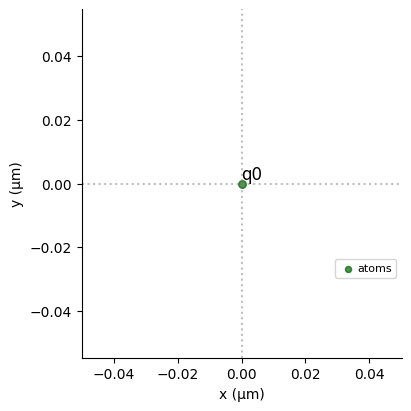

In [206]:
Omega_max = 2.0 * 2 * np.pi
U = Omega_max / 2.0
R_interatomic = MockDevice.rydberg_blockade_radius(U)
reg = Register.square(1, R_interatomic, prefix="q")
print(f"Interatomic Radius is: {R_interatomic}µm.")
reg.draw()

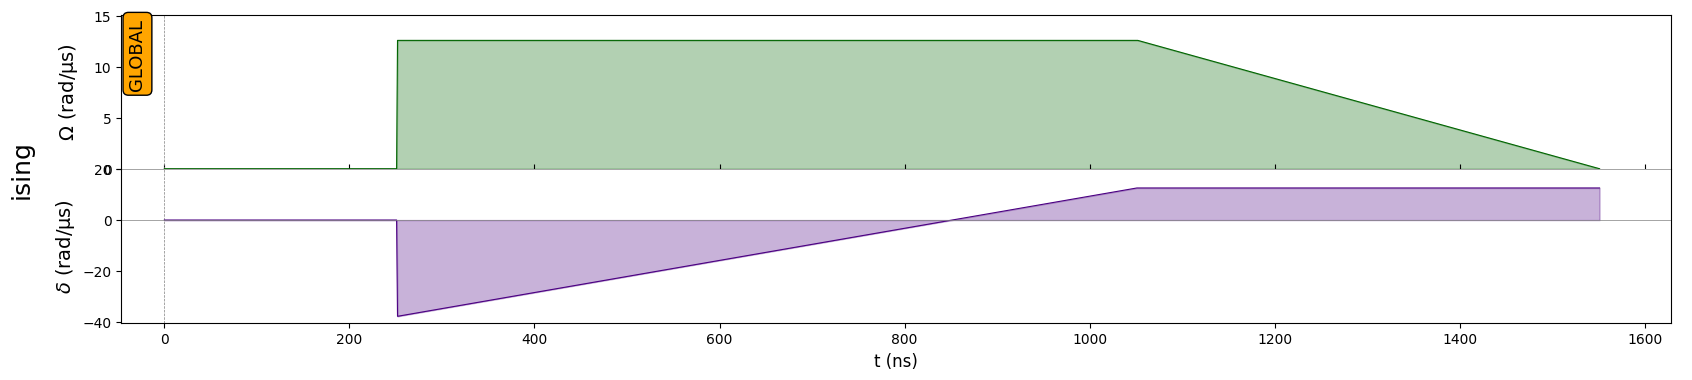

In [207]:
delta_0 = -6 * U
delta_f = 2 * U
t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000
rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0.0, 0.0), 0, 0.0)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0)
seq1 = Sequence(reg, MockDevice)
seq1.declare_channel("ising", "rydberg_global")

seq1.add(rise, "ising")
seq1.add(sweep, "ising")
seq1.add(fall, "ising")

seq1.draw()

In [208]:
sim = QutipEmulator.from_sequence(seq1)

In [209]:
import qse.qbits


L = 3
nqbits = L * L
qsqr = qse.Qbits(positions=np.array([[0, 0, 0]]))


Omega = 1.2  # Amplitude
delta = 2.0  # detuning
C6 = 5420158.53  # interaction scale
nqbits = 1

In [210]:
H1_terms = [qat.core.Term(0.5, "X", [i]) for i in range(qsqr.nqbits)]
H1 = qat.core.Observable(nqbits, pauli_terms=H1_terms)

H2_terms = [qat.core.Term(-0.5, "Z", [i]) for i in range(qsqr.nqbits)]
H2 = qat.core.Observable(nqbits, pauli_terms=H2_terms)

rij = qsqr.get_all_distances()


def occ_op(nqbits, qi):
    ti = qat.core.Term(1.0, "Z", [qi])
    return (1 + qat.core.Observable(nqbits, pauli_terms=[ti])) / 2


#
# H3 = 0

# for i in range(nqbits):
#     for j in range(i + 1, nqbits):
#         H3 += (C6 / rij[i, j]**6) * occ_op(nqbits, i) * occ_op(nqbits, j)

In [211]:
from qat.core.variables import Variable, heaviside
from qat.core import Observable


def create_waveform(times, values):
    """
    A Funnction allowing us to concatenate many lines, limited by heavisides,
    thus creating a continuous, kinked line.
    """
    assert len(times) == len(values)
    # Store the final line as an ArithExpression
    arith_expr = 0
    t_var = Variable("t")
    # A line between each two points
    for entry_i in range(1, len(times)):
        # Create ax + b by calculating the slope and the offset
        a = (values[entry_i] - values[entry_i - 1]) / (
            times[entry_i] - times[entry_i - 1]
        )
        b = (
            (values[entry_i] + values[entry_i - 1])
            - a * (times[entry_i] + times[entry_i - 1])
        ) / 2
        respective_line = a * t_var + b
        arith_expr += (
            heaviside(t_var, times[entry_i - 1], times[entry_i]) * respective_line
        )
    return arith_expr


#
Omega_max = 2.0 * 2 * np.pi
U = Omega_max / 2.0

delta_0 = -6 * U
delta_f = 2 * U

t_rise = 0.252
t_fall = 0.500
t_sweep = ((delta_f - delta_0) / (2 * np.pi * 10) * 1000) * (10**-3)


# The waveform of Omega - for the sigma_x terms
omega_values = [0.0, 0, Omega_max, 0]
times_omega = [0, t_rise, t_rise + t_sweep, t_rise + t_sweep + t_fall]


omega_waveform = create_waveform(times_omega, omega_values)
# The waveform of the detuning Delta - for the 'n' terms
delta_start = -2 * np.pi * 13
delta_end = 2 * np.pi * 11  # R_blockade is taken as 7.5
delta_values = [0, 0, delta_f, delta_f]
delta_waveform = create_waveform(times_omega, delta_values)

In [212]:
from qat.core import Observable

Hamiltonian = Observable(
    [
        (omega_waveform, H1),
        (delta_waveform, H2),
    ]
)

schedule = Schedule(
    drive=[
        (omega_waveform, H1),
        (delta_waveform, H2),
    ],
    tmax=t_rise + t_sweep + t_fall,
)

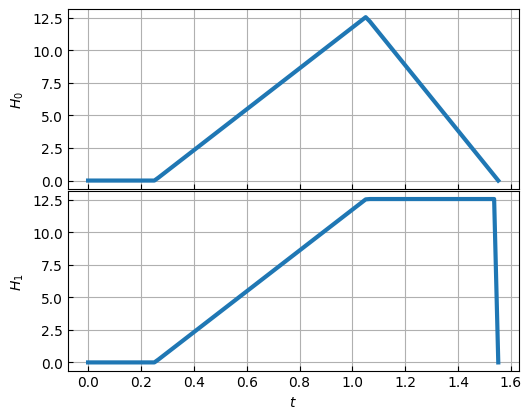

In [213]:
schedule.display()

In [214]:
matrixm = 0 * H1.to_matrix(sparse=False) + 0 * H2.to_matrix(sparse=False)

[[0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


True

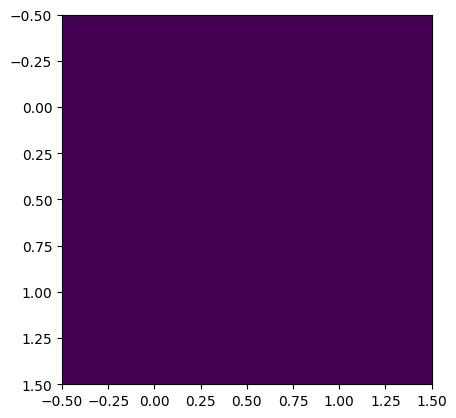

In [215]:
matrixp = sim.get_hamiltonian(0).get_data().toarray()
plt.imshow(matrixp.real)
print(matrixp)
np.savetxt("matrix-p.dat", matrixp.real)
np.all(matrixp.imag == 0)

[[0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


True

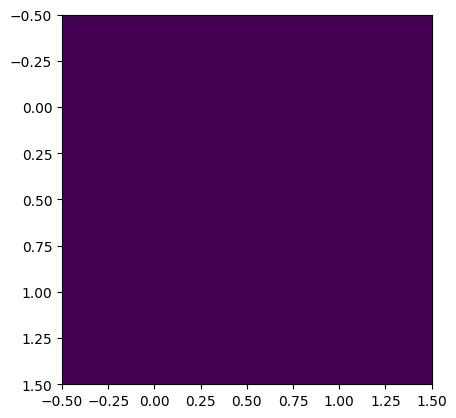

In [216]:
plt.imshow(matrixm.real)
print(matrixm)
np.savetxt("matrix-m.dat", matrixm.real)
np.all(matrixm.imag == 0)

[[0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


True

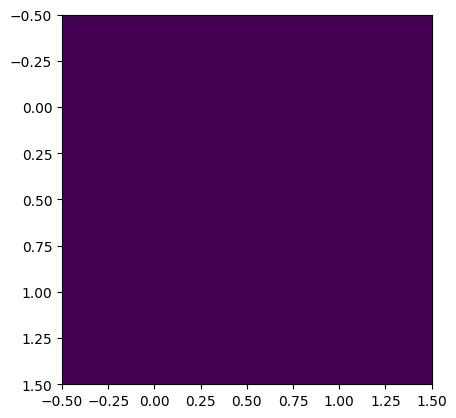

In [217]:
plt.imshow(matrix0.real)
print(matrix0)
np.savetxt("matrix-q.dat", matrix0.real)
np.all(matrix0.imag == 0)

## Testing a one atom setup with 0 amplitude and detuning set to fixed value

Interatomic Radius is: 9.756753962298905µm.


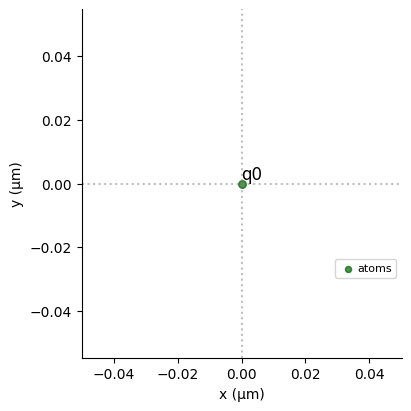

In [353]:
Omega_max = 2.0 * 2 * np.pi
U = Omega_max / 2.0
R_interatomic = MockDevice.rydberg_blockade_radius(U)
reg = Register.square(1, R_interatomic, prefix="q")
print(f"Interatomic Radius is: {R_interatomic}µm.")
reg.draw()

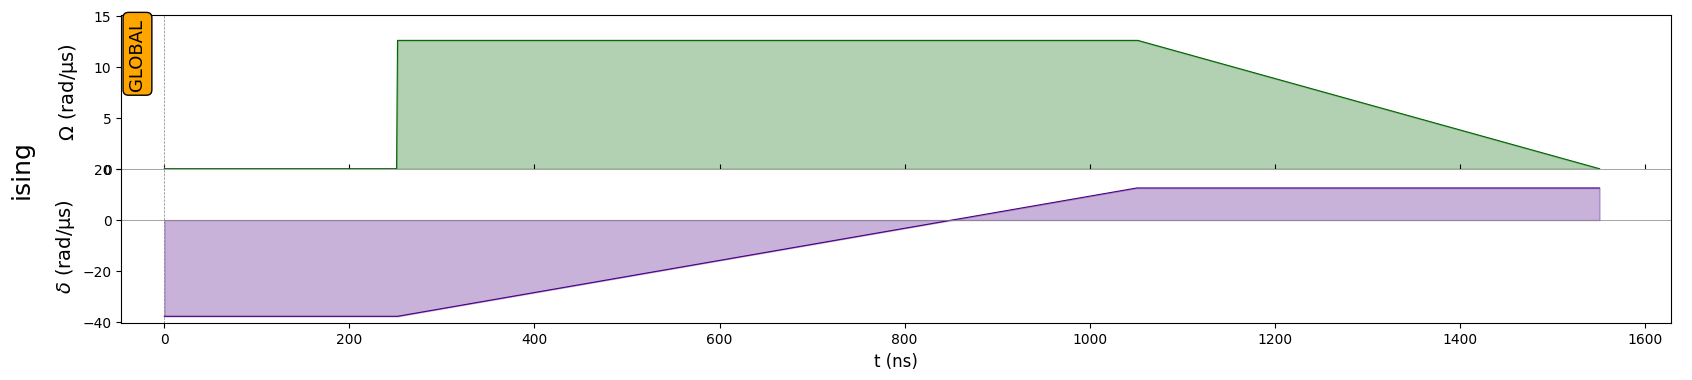

In [354]:
delta_0 = -6 * U
delta_f = 2 * U
t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000
rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0.0, 0.0), delta_0, 0.0)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0)
seq1 = Sequence(reg, MockDevice)
seq1.declare_channel("ising", "rydberg_global")

seq1.add(rise, "ising")
seq1.add(sweep, "ising")
seq1.add(fall, "ising")

seq1.draw()

In [355]:
sim = QutipEmulator.from_sequence(seq1)

In [356]:
import qse.qbits


L = 3
nqbits = L * L
qsqr = qse.Qbits(positions=np.array([[0, 0, 0]]))


Omega = 1.2  # Amplitude
delta = 2.0  # detuning
C6 = 5420158.53  # interaction scale
nqbits = 1

In [357]:
H1_terms = [qat.core.Term(0.5, "X", [i]) for i in range(qsqr.nqbits)]
H1 = qat.core.Observable(nqbits, pauli_terms=H1_terms)

H2_terms = [qat.core.Term(-0.5, "Z", [i]) for i in range(qsqr.nqbits)]
H2 = qat.core.Observable(nqbits, pauli_terms=H2_terms)

rij = qsqr.get_all_distances()


def occ_op(nqbits, qi):
    ti = qat.core.Term(1.0, "Z", [qi])
    return (1 + qat.core.Observable(nqbits, pauli_terms=[ti])) / 2


#
# H3 = 0

# for i in range(nqbits):
#     for j in range(i + 1, nqbits):
#         H3 += (C6 / rij[i, j]**6) * occ_op(nqbits, i) * occ_op(nqbits, j)

In [358]:
from qat.core.variables import Variable, heaviside
from qat.core import Observable


def create_waveform(times, values):
    """
    A Funnction allowing us to concatenate many lines, limited by heavisides,
    thus creating a continuous, kinked line.
    """
    assert len(times) == len(values)
    # Store the final line as an ArithExpression
    arith_expr = 0
    t_var = Variable("t")
    # A line between each two points
    for entry_i in range(1, len(times)):
        # Create ax + b by calculating the slope and the offset
        a = (values[entry_i] - values[entry_i - 1]) / (
            times[entry_i] - times[entry_i - 1]
        )
        b = (
            (values[entry_i] + values[entry_i - 1])
            - a * (times[entry_i] + times[entry_i - 1])
        ) / 2
        respective_line = a * t_var + b
        arith_expr += (
            heaviside(t_var, times[entry_i - 1], times[entry_i]) * respective_line
        )
    return arith_expr


#
Omega_max = 2.0 * 2 * np.pi
U = Omega_max / 2.0

delta_0 = -6 * U
delta_f = 2 * U

t_rise = 0.252
t_fall = 0.500
t_sweep = ((delta_f - delta_0) / (2 * np.pi * 10) * 1000) * (10**-3)


# The waveform of Omega - for the sigma_x terms
omega_values = [0.0, 0, Omega_max, 0]
times_omega = [0, t_rise, t_rise + t_sweep, t_rise + t_sweep + t_fall]


omega_waveform = create_waveform(times_omega, omega_values)
# The waveform of the detuning Delta - for the 'n' terms
delta_start = -2 * np.pi * 13
delta_end = 2 * np.pi * 11  # R_blockade is taken as 7.5
delta_values = [delta_0, 0, delta_f, delta_f]
delta_waveform = create_waveform(times_omega, delta_values)

In [359]:
from qat.core import Observable

Hamiltonian = Observable(
    [
        (omega_waveform, H1),
        (delta_waveform, H2),
    ]
)

schedule = Schedule(
    drive=[
        (omega_waveform, H1),
        (delta_waveform, H2),
    ],
    tmax=t_rise + t_sweep + t_fall,
)

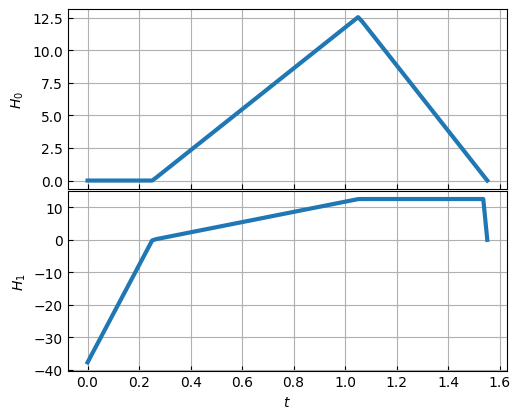

In [360]:
schedule.display()

In [361]:
matrixm = 0 * H1.to_matrix(sparse=False) + delta_0 * H2.to_matrix(sparse=False)

[[37.69911184+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j]]


True

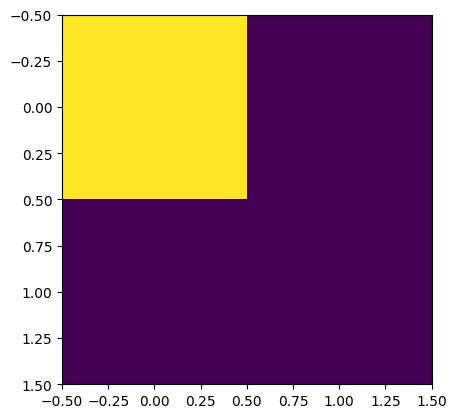

In [362]:
matrixp = sim.get_hamiltonian(0).get_data().toarray()
plt.imshow(matrixp.real)
print(matrixp)
np.savetxt("matrix-p.dat", matrixp.real)
np.all(matrixp.imag == 0)

[[ 18.84955592+0.j   0.        +0.j]
 [  0.        +0.j -18.84955592+0.j]]


True

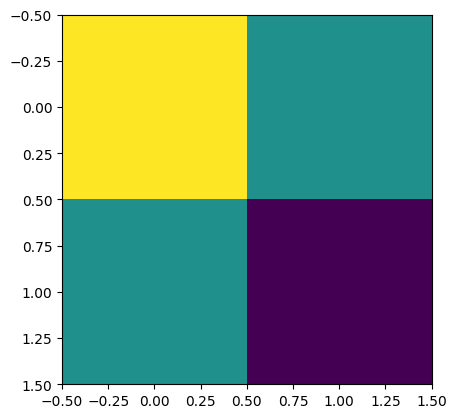

In [363]:
plt.imshow(matrixm.real)
print(matrixm)
np.savetxt("matrix-m.dat", matrixm.real)
np.all(matrixm.imag == 0)

## Testing one atom with Amplitude set to fixed number and detuning to 0


Interatomic Radius is: 9.756753962298905µm.


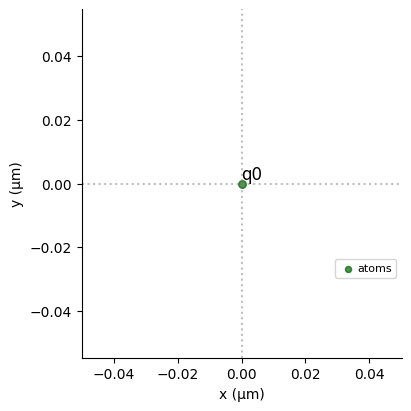

In [229]:
Omega_max = 2.0 * 2 * np.pi
U = Omega_max / 2.0
R_interatomic = MockDevice.rydberg_blockade_radius(U)
reg = Register.square(1, R_interatomic, prefix="q")
print(f"Interatomic Radius is: {R_interatomic}µm.")
reg.draw()

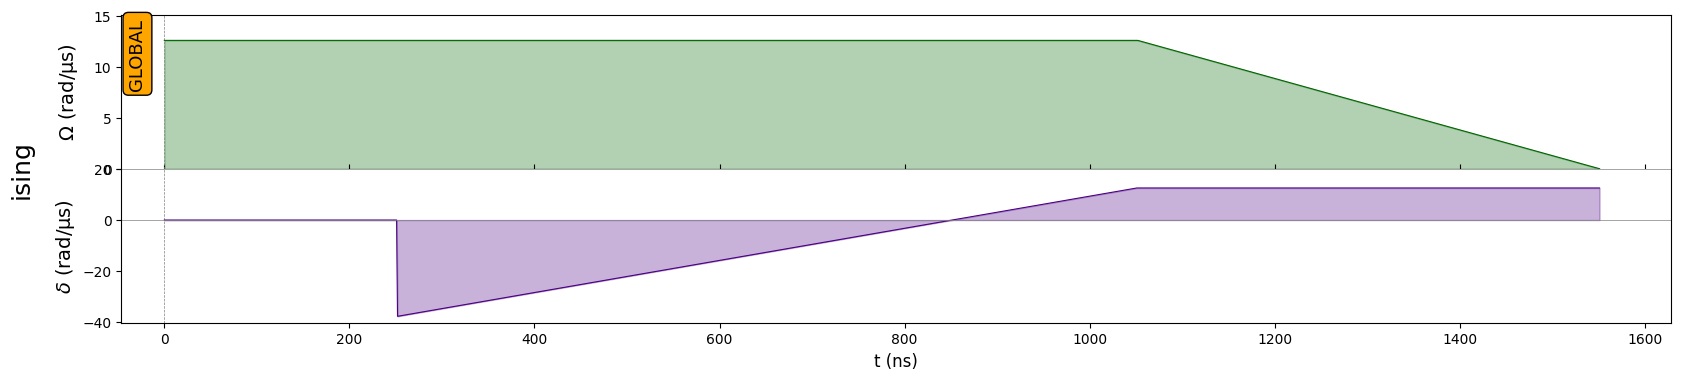

In [230]:
delta_0 = -6 * U
delta_f = 2 * U
t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000
rise = Pulse.ConstantDetuning(RampWaveform(t_rise, Omega_max, Omega_max), 0, 0.0)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0)
seq1 = Sequence(reg, MockDevice)
seq1.declare_channel("ising", "rydberg_global")

seq1.add(rise, "ising")
seq1.add(sweep, "ising")
seq1.add(fall, "ising")

seq1.draw()

In [231]:
sim = QutipEmulator.from_sequence(seq1)

In [232]:
import qse.qbits


L = 3
nqbits = L * L
qsqr = qse.Qbits(positions=np.array([[0, 0, 0]]))


Omega = 1.2  # Amplitude
delta = 2.0  # detuning
C6 = 5420158.53  # interaction scale
nqbits = 1

In [233]:
H1_terms = [qat.core.Term(0.5, "X", [i]) for i in range(qsqr.nqbits)]
H1 = qat.core.Observable(nqbits, pauli_terms=H1_terms)

H2_terms = [qat.core.Term(-0.5, "Z", [i]) for i in range(qsqr.nqbits)]
H2 = qat.core.Observable(nqbits, pauli_terms=H2_terms)

rij = qsqr.get_all_distances()


def occ_op(nqbits, qi):
    ti = qat.core.Term(1.0, "Z", [qi])
    return (1 + qat.core.Observable(nqbits, pauli_terms=[ti])) / 2


#
# H3 = 0

# for i in range(nqbits):
#     for j in range(i + 1, nqbits):
#         H3 += (C6 / rij[i, j]**6) * occ_op(nqbits, i) * occ_op(nqbits, j)

In [234]:
from qat.core.variables import Variable, heaviside
from qat.core import Observable


def create_waveform(times, values):
    """
    A Funnction allowing us to concatenate many lines, limited by heavisides,
    thus creating a continuous, kinked line.
    """
    assert len(times) == len(values)
    # Store the final line as an ArithExpression
    arith_expr = 0
    t_var = Variable("t")
    # A line between each two points
    for entry_i in range(1, len(times)):
        # Create ax + b by calculating the slope and the offset
        a = (values[entry_i] - values[entry_i - 1]) / (
            times[entry_i] - times[entry_i - 1]
        )
        b = (
            (values[entry_i] + values[entry_i - 1])
            - a * (times[entry_i] + times[entry_i - 1])
        ) / 2
        respective_line = a * t_var + b
        arith_expr += (
            heaviside(t_var, times[entry_i - 1], times[entry_i]) * respective_line
        )
    return arith_expr


#
Omega_max = 2.0 * 2 * np.pi
U = Omega_max / 2.0

delta_0 = -6 * U
delta_f = 2 * U

t_rise = 0.252
t_fall = 0.500
t_sweep = ((delta_f - delta_0) / (2 * np.pi * 10) * 1000) * (10**-3)


# The waveform of Omega - for the sigma_x terms
omega_values = [Omega_max, 0, Omega_max, 0]
times_omega = [0, t_rise, t_rise + t_sweep, t_rise + t_sweep + t_fall]


omega_waveform = create_waveform(times_omega, omega_values)
# The waveform of the detuning Delta - for the 'n' terms
delta_start = -2 * np.pi * 13
delta_end = 2 * np.pi * 11  # R_blockade is taken as 7.5
delta_values = [0, 0, delta_f, delta_f]
delta_waveform = create_waveform(times_omega, delta_values)

In [235]:
from qat.core import Observable

Hamiltonian = Observable(
    [
        (omega_waveform, H1),
        (delta_waveform, H2),
    ]
)

schedule = Schedule(
    drive=[
        (omega_waveform, H1),
        (delta_waveform, H2),
    ],
    tmax=t_rise + t_sweep + t_fall,
)

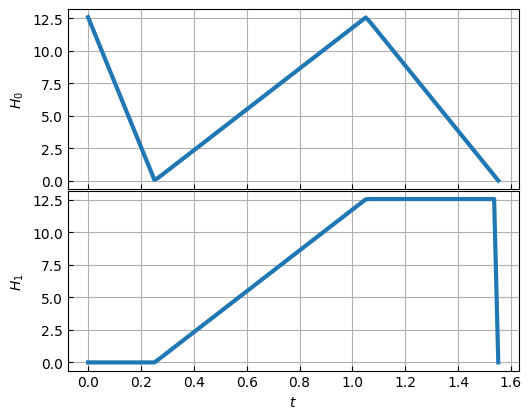

In [236]:
schedule.display()

In [237]:
matrixm = Omega_max * H1.to_matrix(sparse=False) + 0 * H2.to_matrix(sparse=False)

[[0.        +0.j 6.28318531+0.j]
 [6.28318531+0.j 0.        +0.j]]


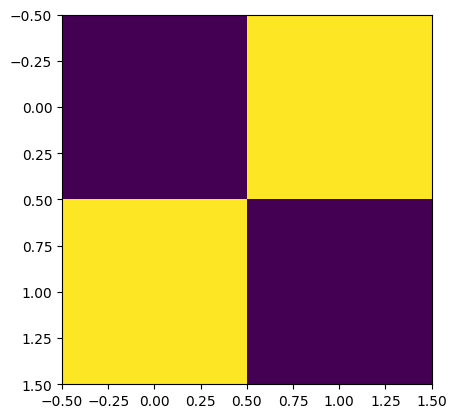

In [238]:
matrixp = sim.get_hamiltonian(0).get_data().toarray()
plt.imshow(matrixp.real)
print(matrixp)
np.savetxt("matrix-p.dat", matrixp.real)

[[0.        +0.j 6.28318531+0.j]
 [6.28318531+0.j 0.        +0.j]]


True

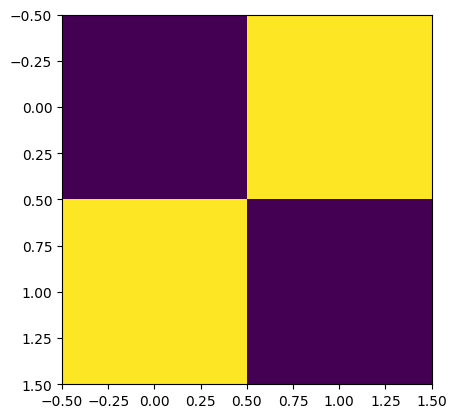

In [239]:
plt.imshow(matrixm.real)
print(matrixm)
np.savetxt("matrix-m.dat", matrixm.real)
np.all(matrixm.imag == 0)

## Testing a one atom setup with 0 amplitude and detuning checking interaction term

Interatomic Radius is: 9.756753962298905µm.


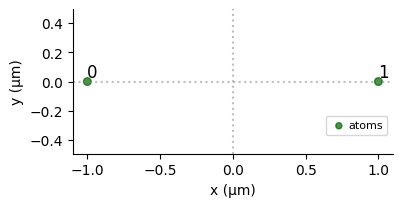

In [241]:
Omega_max = 2.0 * 2 * np.pi
U = Omega_max / 2.0
R_interatomic = MockDevice.rydberg_blockade_radius(U)
reg = Register.from_coordinates([[0, 0], [2, 0]])
print(f"Interatomic Radius is: {R_interatomic}µm.")
reg.draw()

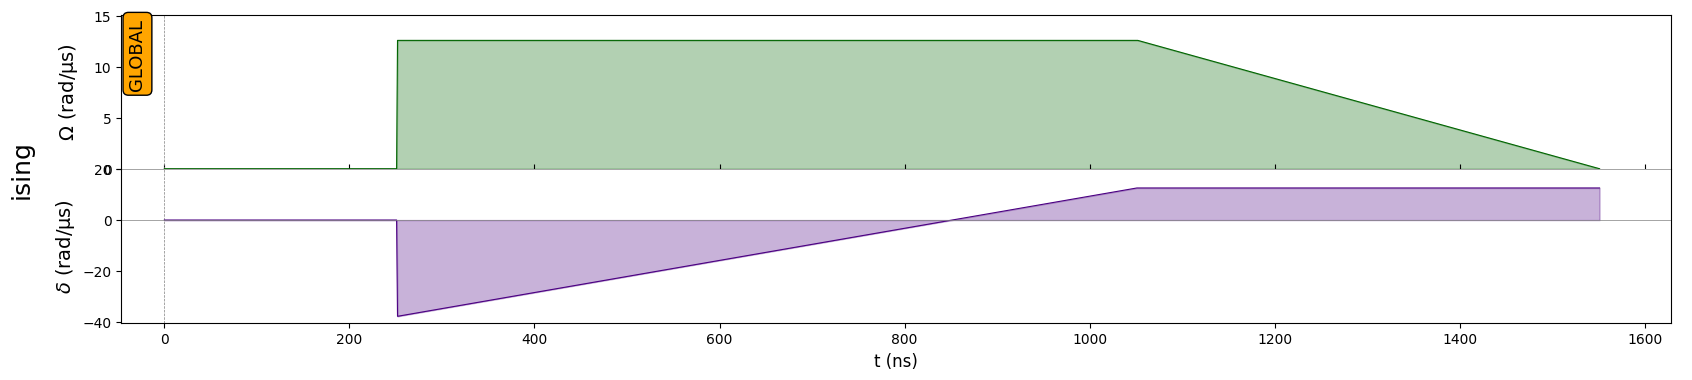

In [242]:
delta_0 = -6 * U
delta_f = 2 * U
t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000
rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0.0, 0.0), 0, 0.0)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0)
seq1 = Sequence(reg, MockDevice)
seq1.declare_channel("ising", "rydberg_global")

seq1.add(rise, "ising")
seq1.add(sweep, "ising")
seq1.add(fall, "ising")

seq1.draw()

In [243]:
sim = QutipEmulator.from_sequence(seq1)

In [244]:
import qse.qbits


L = 3
nqbits = L * L
qsqr = qse.Qbits(positions=np.array([[0, 0, 0], [2, 0, 0]]))


Omega = 1.2  # Amplitude
delta = 2.0  # detuning
C6 = 5420158.53  # interaction scale
nqbits = 2

In [245]:
H1_terms = [qat.core.Term(0.5, "X", [i]) for i in range(qsqr.nqbits)]
H1 = qat.core.Observable(nqbits, pauli_terms=H1_terms)

H2_terms = [qat.core.Term(-0.5, "Z", [i]) for i in range(qsqr.nqbits)]
H2 = qat.core.Observable(nqbits, pauli_terms=H2_terms)

rij = qsqr.get_all_distances()


def occ_op(nqbits, qi):
    ti = qat.core.Term(1.0, "Z", [qi])
    return (1 + qat.core.Observable(nqbits, pauli_terms=[ti])) / 2


#
H3 = 0

for i in range(nqbits):
    for j in range(i + 1, nqbits):
        H3 += (C6 / rij[i, j] ** 6) * occ_op(nqbits, i) * occ_op(nqbits, j)

In [246]:
from qat.core.variables import Variable, heaviside
from qat.core import Observable


def create_waveform(times, values):
    """
    A Funnction allowing us to concatenate many lines, limited by heavisides,
    thus creating a continuous, kinked line.
    """
    assert len(times) == len(values)
    # Store the final line as an ArithExpression
    arith_expr = 0
    t_var = Variable("t")
    # A line between each two points
    for entry_i in range(1, len(times)):
        # Create ax + b by calculating the slope and the offset
        a = (values[entry_i] - values[entry_i - 1]) / (
            times[entry_i] - times[entry_i - 1]
        )
        b = (
            (values[entry_i] + values[entry_i - 1])
            - a * (times[entry_i] + times[entry_i - 1])
        ) / 2
        respective_line = a * t_var + b
        arith_expr += (
            heaviside(t_var, times[entry_i - 1], times[entry_i]) * respective_line
        )
    return arith_expr


#
Omega_max = 2.0 * 2 * np.pi
U = Omega_max / 2.0

delta_0 = -6 * U
delta_f = 2 * U

t_rise = 0.252
t_fall = 0.500
t_sweep = ((delta_f - delta_0) / (2 * np.pi * 10) * 1000) * (10**-3)


# The waveform of Omega - for the sigma_x terms
omega_values = [0.0, 0, Omega_max, 0]
times_omega = [0, t_rise, t_rise + t_sweep, t_rise + t_sweep + t_fall]


omega_waveform = create_waveform(times_omega, omega_values)
# The waveform of the detuning Delta - for the 'n' terms
delta_start = -2 * np.pi * 13
delta_end = 2 * np.pi * 11  # R_blockade is taken as 7.5
delta_values = [0, 0, delta_f, delta_f]
delta_waveform = create_waveform(times_omega, delta_values)

In [247]:
from qat.core import Observable

Hamiltonian = Observable(
    [
        (omega_waveform, H1),
        (delta_waveform, H2),
    ]
)

schedule = Schedule(
    drive=[
        (omega_waveform, H1),
        (delta_waveform, H2),
    ],
    tmax=t_rise + t_sweep + t_fall,
)

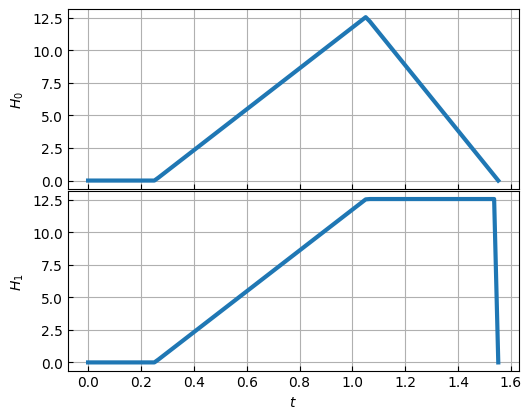

In [248]:
schedule.display()

In [249]:
matrixm = (
    0 * H1.to_matrix(sparse=False)
    + 0 * H2.to_matrix(sparse=False)
    + H3.to_matrix(sparse=False)
)

In [250]:
H3.to_matrix(sparse=False)

array([[84689.97703125+0.j,     0.        +0.j,     0.        +0.j,
            0.        +0.j],
       [    0.        +0.j,     0.        +0.j,     0.        +0.j,
            0.        +0.j],
       [    0.        +0.j,     0.        +0.j,     0.        +0.j,
            0.        +0.j],
       [    0.        +0.j,     0.        +0.j,     0.        +0.j,
            0.        +0.j]])

[[84689.97703125+0.j     0.        +0.j     0.        +0.j
      0.        +0.j]
 [    0.        +0.j     0.        +0.j     0.        +0.j
      0.        +0.j]
 [    0.        +0.j     0.        +0.j     0.        +0.j
      0.        +0.j]
 [    0.        +0.j     0.        +0.j     0.        +0.j
      0.        +0.j]]


True

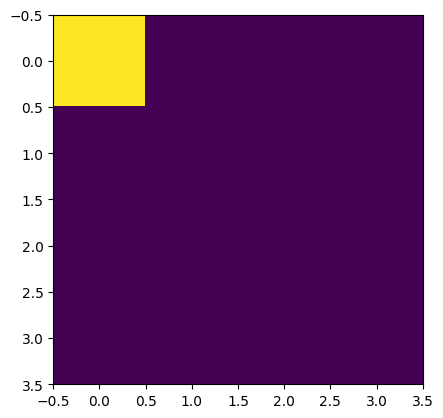

In [251]:
matrixp = sim.get_hamiltonian(0).get_data().toarray()
plt.imshow(matrixp.real)
print(matrixp)
np.savetxt("matrix-p.dat", matrixp.real)
np.all(matrixp.imag == 0)

[[84689.97703125+0.j     0.        +0.j     0.        +0.j
      0.        +0.j]
 [    0.        +0.j     0.        +0.j     0.        +0.j
      0.        +0.j]
 [    0.        +0.j     0.        +0.j     0.        +0.j
      0.        +0.j]
 [    0.        +0.j     0.        +0.j     0.        +0.j
      0.        +0.j]]


True

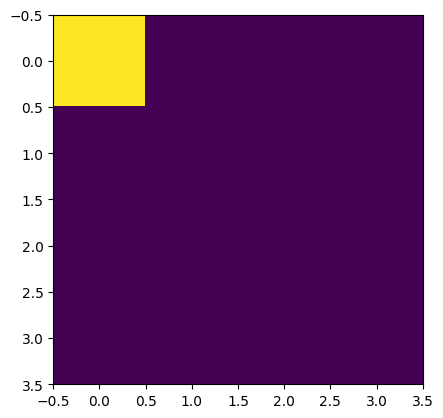

In [252]:
plt.imshow(matrixm.real)
print(matrixm)
np.savetxt("matrix-m.dat", matrixm.real)
np.all(matrixm.imag == 0)

## Testing more atoms with 0 amplitude and detuning checking interaction term

Interatomic Radius is: 9.756753962298905µm.


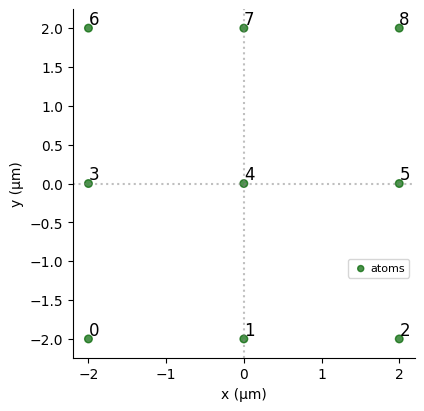

In [255]:
Omega_max = 2.0 * 2 * np.pi
U = Omega_max / 2.0
R_interatomic = MockDevice.rydberg_blockade_radius(U)
reg = Register.from_coordinates(
    [[0, 0], [2, 0], [4, 0], [0, 2], [2, 2], [4, 2], [0, 4], [2, 4], [4, 4]]
)
print(f"Interatomic Radius is: {R_interatomic}µm.")
reg.draw()

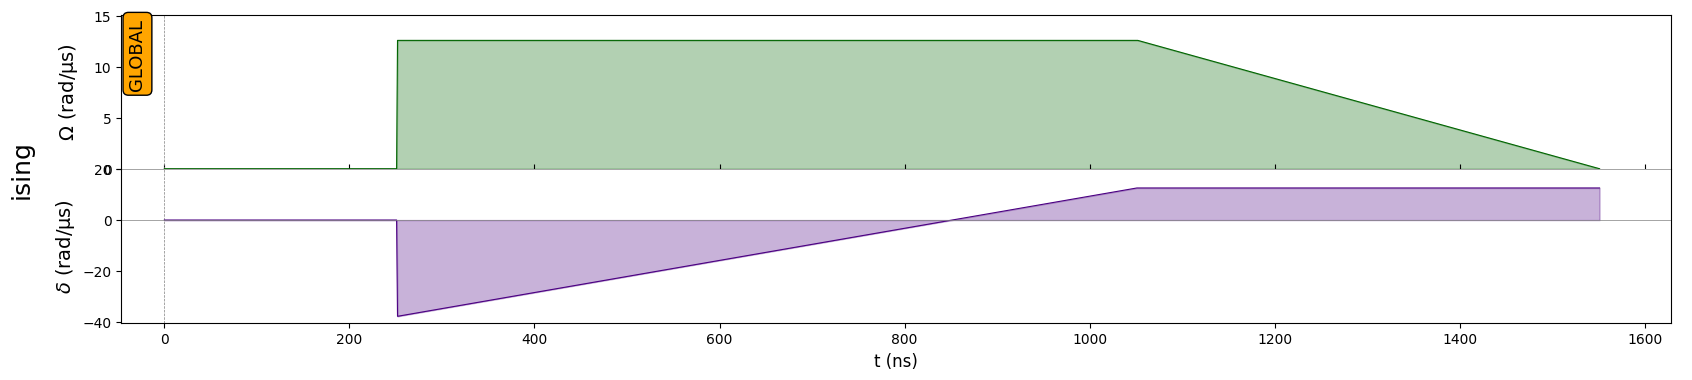

In [256]:
delta_0 = -6 * U
delta_f = 2 * U
t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000
rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0.0, 0.0), 0, 0.0)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0)
seq1 = Sequence(reg, MockDevice)
seq1.declare_channel("ising", "rydberg_global")

seq1.add(rise, "ising")
seq1.add(sweep, "ising")
seq1.add(fall, "ising")

seq1.draw()

In [257]:
sim = QutipEmulator.from_sequence(seq1)

In [268]:
import qse.qbits


L = 3
nqbits = L * L
qsqr = qse.Qbits(
    positions=np.array(
        [
            [0, 0, 0],
            [2, 0, 0],
            [4, 0, 0],
            [0, 2, 0],
            [2, 2, 0],
            [4, 2, 0],
            [0, 4, 0],
            [2, 4, 0],
            [4, 4, 0],
        ]
    )
)


Omega = 1.2  # Amplitude
delta = 2.0  # detuning
C6 = 5420158.53  # interaction scale

In [269]:
H1_terms = [qat.core.Term(0.5, "X", [i]) for i in range(qsqr.nqbits)]
H1 = qat.core.Observable(nqbits, pauli_terms=H1_terms)

H2_terms = [qat.core.Term(-0.5, "Z", [i]) for i in range(qsqr.nqbits)]
H2 = qat.core.Observable(nqbits, pauli_terms=H2_terms)

rij = qsqr.get_all_distances()


def occ_op(nqbits, qi):
    ti = qat.core.Term(1.0, "Z", [qi])
    return (1 + qat.core.Observable(nqbits, pauli_terms=[ti])) / 2


#
H3 = 0

for i in range(nqbits):
    for j in range(i + 1, nqbits):
        H3 += (C6 / rij[i, j] ** 6) * occ_op(nqbits, i) * occ_op(nqbits, j)

In [270]:
from qat.core.variables import Variable, heaviside
from qat.core import Observable


def create_waveform(times, values):
    """
    A Funnction allowing us to concatenate many lines, limited by heavisides,
    thus creating a continuous, kinked line.
    """
    assert len(times) == len(values)
    # Store the final line as an ArithExpression
    arith_expr = 0
    t_var = Variable("t")
    # A line between each two points
    for entry_i in range(1, len(times)):
        # Create ax + b by calculating the slope and the offset
        a = (values[entry_i] - values[entry_i - 1]) / (
            times[entry_i] - times[entry_i - 1]
        )
        b = (
            (values[entry_i] + values[entry_i - 1])
            - a * (times[entry_i] + times[entry_i - 1])
        ) / 2
        respective_line = a * t_var + b
        arith_expr += (
            heaviside(t_var, times[entry_i - 1], times[entry_i]) * respective_line
        )
    return arith_expr


#
Omega_max = 2.0 * 2 * np.pi
U = Omega_max / 2.0

delta_0 = -6 * U
delta_f = 2 * U

t_rise = 0.252
t_fall = 0.500
t_sweep = ((delta_f - delta_0) / (2 * np.pi * 10) * 1000) * (10**-3)


# The waveform of Omega - for the sigma_x terms
omega_values = [0.0, 0, Omega_max, 0]
times_omega = [0, t_rise, t_rise + t_sweep, t_rise + t_sweep + t_fall]


omega_waveform = create_waveform(times_omega, omega_values)
# The waveform of the detuning Delta - for the 'n' terms
delta_start = -2 * np.pi * 13
delta_end = 2 * np.pi * 11  # R_blockade is taken as 7.5
delta_values = [0, 0, delta_f, delta_f]
delta_waveform = create_waveform(times_omega, delta_values)

In [271]:
from qat.core import Observable

Hamiltonian = Observable(
    [
        (omega_waveform, H1),
        (delta_waveform, H2),
    ]
)

schedule = Schedule(
    drive=[
        (omega_waveform, H1),
        (delta_waveform, H2),
    ],
    tmax=t_rise + t_sweep + t_fall,
)

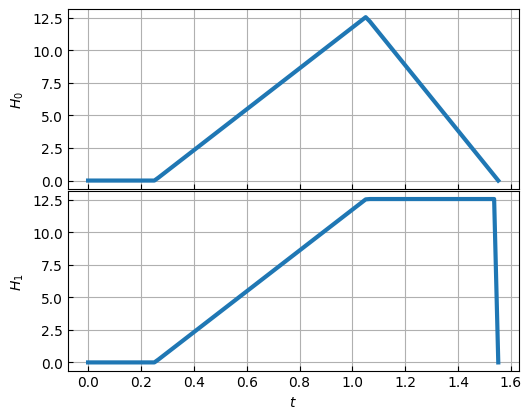

In [272]:
schedule.display()

In [273]:
matrixm = (
    0 * H1.to_matrix(sparse=False)
    + 0 * H2.to_matrix(sparse=False)
    + H3.to_matrix(sparse=False)
)

In [274]:
H3.to_matrix(sparse=False)

array([[ 1.11466037e+06+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        ...,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  9.30527153e+05+0.j,  0.00000000e+00+0.j,
        ...,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  8.36739620e+05+0.j,
        ...,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       ...,
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        ..., -6.18456397e-11+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        ...,  0.00000000e+00+0.j, -2.54658516e-11+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        ...,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        -8.36735126e-11+0.j]])

[[1114660.36550571+0.j       0.        +0.j       0.        +0.j ...
        0.        +0.j       0.        +0.j       0.        +0.j]
 [      0.        +0.j  930527.15278819+0.j       0.        +0.j ...
        0.        +0.j       0.        +0.j       0.        +0.j]
 [      0.        +0.j       0.        +0.j  836739.61963053+0.j ...
        0.        +0.j       0.        +0.j       0.        +0.j]
 ...
 [      0.        +0.j       0.        +0.j       0.        +0.j ...
        0.        +0.j       0.        +0.j       0.        +0.j]
 [      0.        +0.j       0.        +0.j       0.        +0.j ...
        0.        +0.j       0.        +0.j       0.        +0.j]
 [      0.        +0.j       0.        +0.j       0.        +0.j ...
        0.        +0.j       0.        +0.j       0.        +0.j]]


True

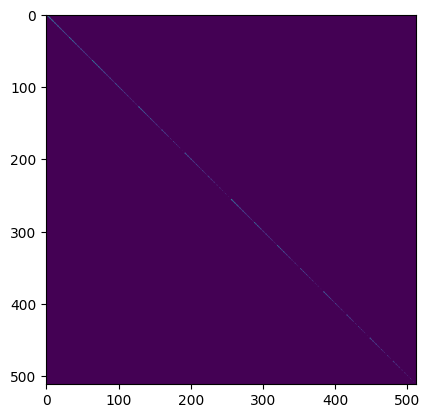

In [275]:
matrixp = sim.get_hamiltonian(0).get_data().toarray()
plt.imshow(matrixp.real)
print(matrixp)
np.savetxt("matrix-p.dat", matrixp.real)
np.all(matrixp.imag == 0)

[[ 1.11466037e+06+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  9.30527153e+05+0.j  0.00000000e+00+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  8.36739620e+05+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 ...
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
  -6.18456397e-11+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
   0.00000000e+00+0.j -2.54658516e-11+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j -8.36735126e-11+0.j]]


True

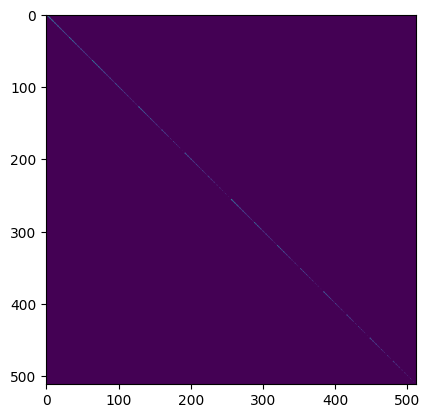

In [276]:
plt.imshow(matrixm.real)
print(matrixm)
np.savetxt("matrix-m.dat", matrixm.real)
np.all(matrixm.imag == 0)

In [277]:
np.savetxt("matrix-q.dat", matrixm.real)
np.savetxt("matrix-p.dat", matrixp.real)

True

[[ 1. nan nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]
 [nan nan  1. ... nan nan nan]
 ...
 [nan nan nan ... -0. nan nan]
 [nan nan nan ... nan -0. nan]
 [nan nan nan ... nan nan -0.]]


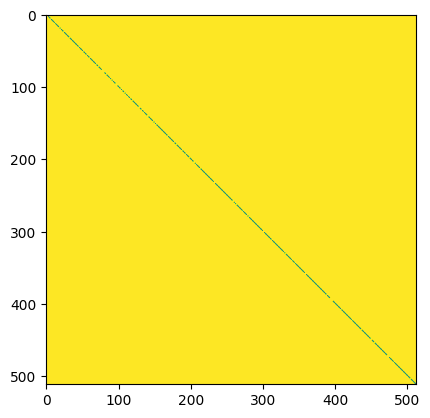

In [288]:
p = np.loadtxt("matrix-p.dat")
q = np.loadtxt("matrix-q.dat")
plt.imshow(p == q)

pd = p.diagonal()
qd = q.diagonal()
print(p / q)

In [291]:
print(pd / qd)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

In [290]:
print(qd)

[ 1.11466037e+06  9.30527153e+05  8.36739620e+05  7.37296384e+05
  9.30527153e+05  7.47717221e+05  7.37296384e+05  6.39176429e+05
  8.36739620e+05  7.37296384e+05  5.69405121e+05  5.54651862e+05
  6.53283927e+05  5.55163972e+05  4.70639405e+05  4.57209427e+05
  7.33555469e+05  5.60008503e+05  5.40324700e+05  4.51467711e+05
  5.60008503e+05  3.87784819e+05  4.51467711e+05  3.63934004e+05
  5.40324700e+05  4.51467711e+05  3.57680178e+05  3.53513167e+05
  3.67455254e+05  2.79921547e+05  2.69500710e+05  2.66656979e+05
  8.36739620e+05  6.53283927e+05  5.69405121e+05  4.70639405e+05
  7.37296384e+05  5.55163972e+05  5.54651862e+05  4.57209427e+05
  5.60142155e+05  4.61376439e+05  3.03393903e+05  2.89318164e+05
  4.61376439e+05  3.63934004e+05  2.89318164e+05  2.76565706e+05
  5.40324700e+05  3.67455254e+05  3.57680178e+05  2.69500710e+05
  4.51467711e+05  2.79921547e+05  3.53513167e+05  2.66656979e+05
  3.48417212e+05  2.60237743e+05  1.76358937e+05  1.72869446e+05
  2.60237743e+05  1.73381

## Testing more atoms with fixed amplitude and 0 detuning checking interaction term

Interatomic Radius is: 9.756753962298905µm.


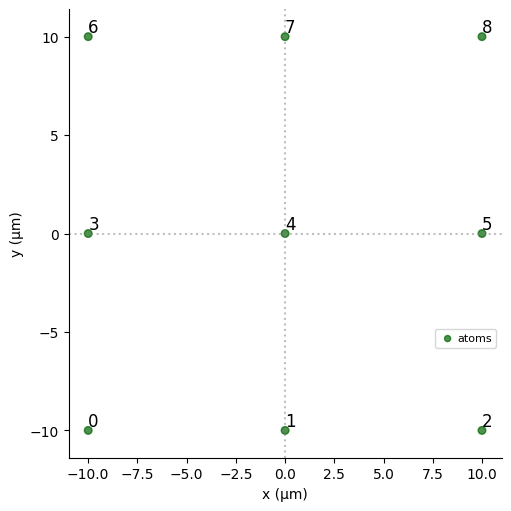

In [314]:
Omega_max = 2.0 * 2 * np.pi
U = Omega_max / 2.0
R_interatomic = MockDevice.rydberg_blockade_radius(U)
reg = Register.from_coordinates(
    [[0, 0], [10, 0], [20, 0], [0, 10], [10, 10], [20, 10], [0, 20], [10, 20], [20, 20]]
)
print(f"Interatomic Radius is: {R_interatomic}µm.")
reg.draw()

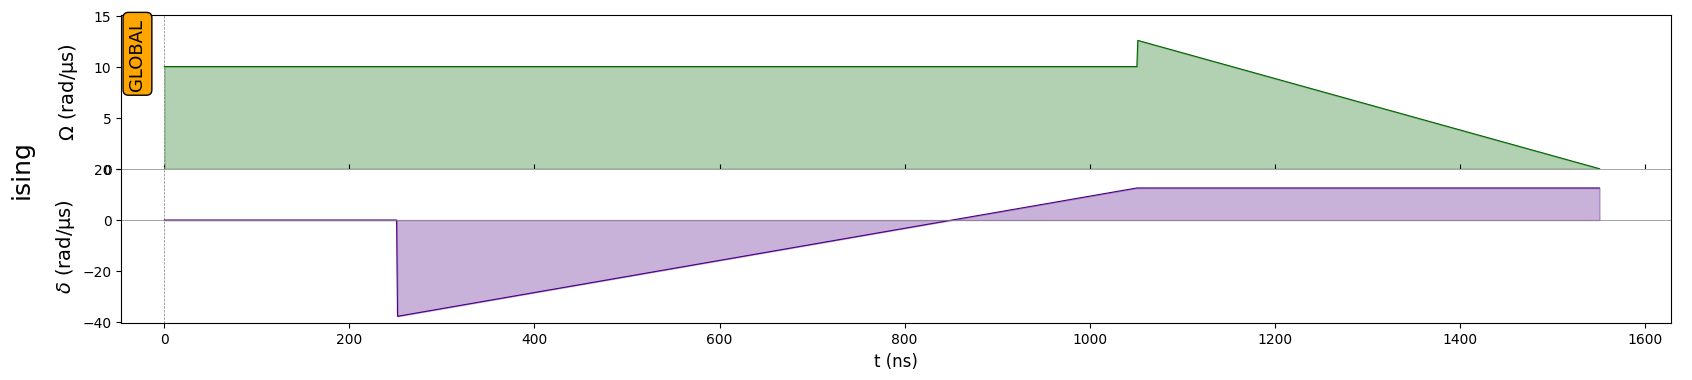

In [325]:
delta_0 = -6 * U
delta_f = 2 * U
t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000
rise = Pulse.ConstantAmplitude(10, RampWaveform(t_rise, 0.0, 0.0), 0.0)
sweep = Pulse.ConstantAmplitude(10, RampWaveform(t_sweep, delta_0, delta_f), 0.0)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0)
seq1 = Sequence(reg, MockDevice)
seq1.declare_channel("ising", "rydberg_global")

seq1.add(rise, "ising")
seq1.add(sweep, "ising")
seq1.add(fall, "ising")

seq1.draw()

In [326]:
sim = QutipEmulator.from_sequence(seq1)

In [327]:
results = sim.run(progress_bar=True)

10.0%. Run time:   0.07s. Est. time left: 00:00:00:00
20.0%. Run time:   0.15s. Est. time left: 00:00:00:00
30.0%. Run time:   0.23s. Est. time left: 00:00:00:00
40.1%. Run time:   0.31s. Est. time left: 00:00:00:00
50.0%. Run time:   0.37s. Est. time left: 00:00:00:00
60.0%. Run time:   0.43s. Est. time left: 00:00:00:00
70.1%. Run time:   0.49s. Est. time left: 00:00:00:00
80.0%. Run time:   0.55s. Est. time left: 00:00:00:00
90.0%. Run time:   0.61s. Est. time left: 00:00:00:00
Total run time:   0.66s


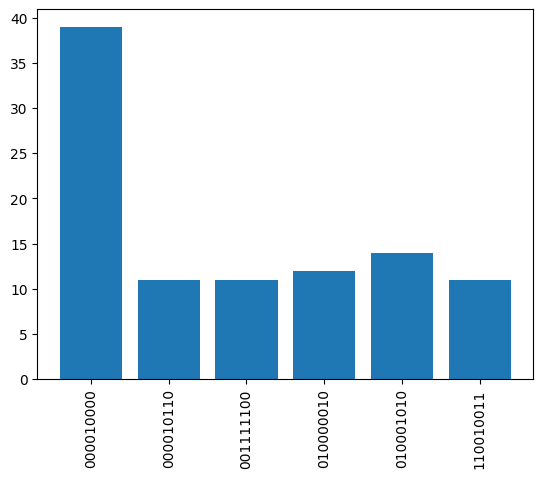

In [328]:
import matplotlib.pyplot as plt

count = results.sample_final_state()

most_freq = {k: v for k, v in count.items() if v > 10}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.show()

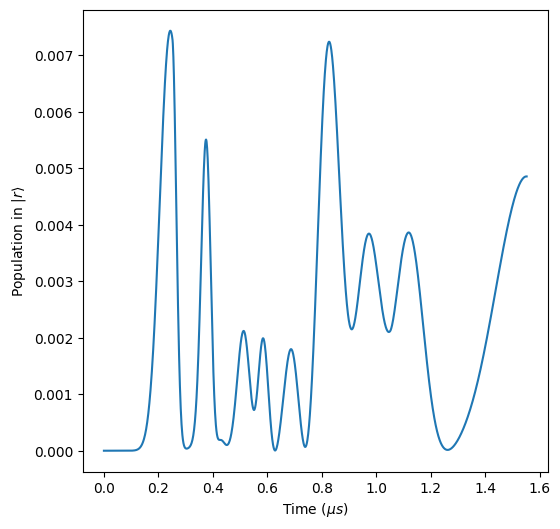

In [329]:
# Define Rydberg state observable
obs = qutip.basis(256 * 2, 0).proj()
plt.figure(figsize=(6, 6))
k = results.expect([obs])[0]

plt.plot(results._sim_times, k)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"Population in $|r\rangle$")
plt.show()

crank = 0, prank = 2
rcut is 10.0


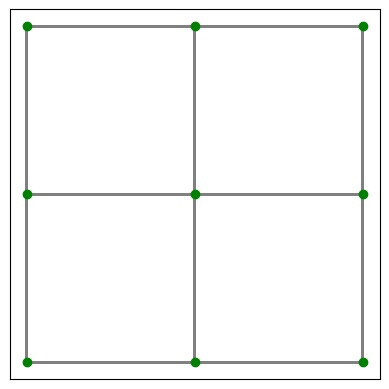

In [341]:
import qse.qbits


L = 3
nqbits = L * L
qsqr = qse.Qbits(
    positions=np.array(
        [
            [0, 0, 0],
            [10, 0, 0],
            [20, 0, 0],
            [0, 10, 0],
            [10, 10, 0],
            [20, 10, 0],
            [0, 20, 0],
            [10, 20, 0],
            [20, 20, 0],
        ]
    )
)


Omega = 1.2  # Amplitude
delta = 2.0  # detuning
C6 = 5420158.53  # interaction scale

qsqr.draw()

In [331]:
H1_terms = [qat.core.Term(0.5, "X", [i]) for i in range(qsqr.nqbits)]
H1 = qat.core.Observable(nqbits, pauli_terms=H1_terms)

H2_terms = [qat.core.Term(-0.5, "Z", [i]) for i in range(qsqr.nqbits)]
H2 = qat.core.Observable(nqbits, pauli_terms=H2_terms)

rij = qsqr.get_all_distances()


def occ_op(nqbits, qi):
    ti = qat.core.Term(1.0, "Z", [qi])
    return (1 + qat.core.Observable(nqbits, pauli_terms=[ti])) / 2


#
H3 = 0

for i in range(nqbits):
    for j in range(i + 1, nqbits):
        H3 += (C6 / rij[i, j] ** 6) * occ_op(nqbits, i) * occ_op(nqbits, j)

In [342]:
from qat.core.variables import Variable, heaviside
from qat.core import Observable


def create_waveform(times, values):
    """
    A Funnction allowing us to concatenate many lines, limited by heavisides,
    thus creating a continuous, kinked line.
    """
    assert len(times) == len(values)
    # Store the final line as an ArithExpression
    arith_expr = 0
    t_var = Variable("t")
    # A line between each two points
    for entry_i in range(1, len(times)):
        # Create ax + b by calculating the slope and the offset
        a = (values[entry_i] - values[entry_i - 1]) / (
            times[entry_i] - times[entry_i - 1]
        )
        b = (
            (values[entry_i] + values[entry_i - 1])
            - a * (times[entry_i] + times[entry_i - 1])
        ) / 2
        respective_line = a * t_var + b
        arith_expr += (
            heaviside(t_var, times[entry_i - 1], times[entry_i]) * respective_line
        )
    return arith_expr


#
Omega_max = 2.0 * 2 * np.pi
U = Omega_max / 2.0

delta_0 = -6 * U
delta_f = 2 * U

t_rise = 0.252
t_fall = 0.500
t_sweep = ((delta_f - delta_0) / (2 * np.pi * 10) * 1000) * (10**-3)


# The waveform of Omega - for the sigma_x terms
omega_values = [10.0, 0, Omega_max, 0]
times_omega = [0, t_rise, t_rise + t_sweep, t_rise + t_sweep + t_fall]


omega_waveform = create_waveform(times_omega, omega_values)
# The waveform of the detuning Delta - for the 'n' terms
delta_start = -2 * np.pi * 13
delta_end = 2 * np.pi * 11  # R_blockade is taken as 7.5
delta_values = [0, 0, delta_f, delta_f]
delta_waveform = create_waveform(times_omega, delta_values)

In [343]:
from qat.core import Observable

Hamiltonian = Observable(
    [
        (omega_waveform, H1),
        (delta_waveform, H2),
    ]
)

schedule = Schedule(
    drive=[
        (omega_waveform, H1),
        (delta_waveform, H2),
    ],
    tmax=t_rise + t_sweep + t_fall,
)

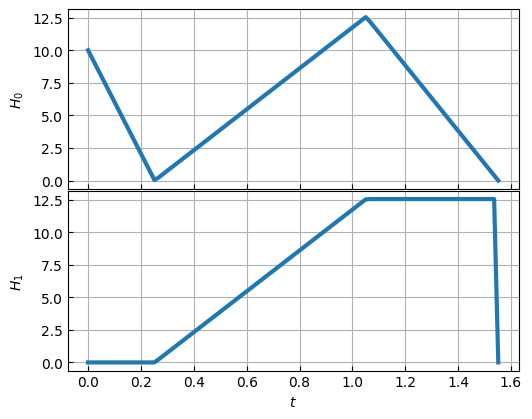

In [344]:
schedule.display()

In [345]:
matrixm = (
    10 * H1.to_matrix(sparse=False)
    + 0 * H2.to_matrix(sparse=False)
    + H3.to_matrix(sparse=False)
)

In [346]:
H3.to_matrix(sparse=False)

array([[ 7.13382634e+01+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        ...,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  5.95537378e+01+0.j,  0.00000000e+00+0.j,
        ...,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  5.35513357e+01+0.j,
        ...,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       ...,
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        ..., -4.88498131e-15+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        ...,  0.00000000e+00+0.j, -1.11022302e-14+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        ...,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        -4.88498131e-15+0.j]])

[[71.33826339+0.j  5.        +0.j  5.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 5.        +0.j 59.55373778+0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 5.        +0.j  0.        +0.j 53.55133566+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 ...
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  5.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  5.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  5.        +0.j
   5.        +0.j  0.        +0.j]]


True

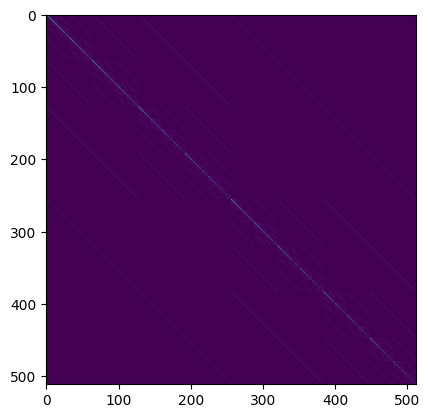

In [347]:
matrixp = sim.get_hamiltonian(0).get_data().toarray()
plt.imshow(matrixp.real)
print(matrixp)
np.savetxt("matrix-p.dat", matrixp.real)
np.all(matrixp.imag == 0)

[[ 7.13382634e+01+0.j  5.00000000e+00+0.j  5.00000000e+00+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 5.00000000e+00+0.j  5.95537378e+01+0.j  0.00000000e+00+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 5.00000000e+00+0.j  0.00000000e+00+0.j  5.35513357e+01+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 ...
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
  -4.88498131e-15+0.j  0.00000000e+00+0.j  5.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
   0.00000000e+00+0.j -1.11022302e-14+0.j  5.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
   5.00000000e+00+0.j  5.00000000e+00+0.j -4.88498131e-15+0.j]]


True

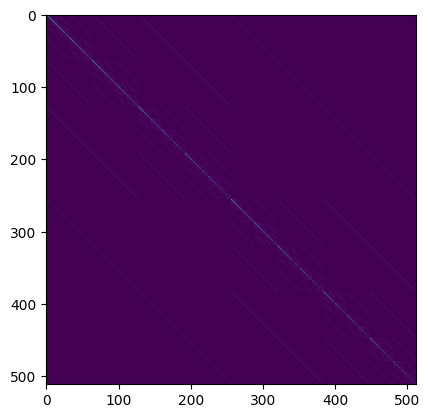

In [348]:
plt.imshow(matrixm.real)
print(matrixm)
np.savetxt("matrix-m.dat", matrixm.real)
np.all(matrixm.imag == 0)

In [349]:
np.savetxt("matrix-q.dat", matrixm.real)
np.savetxt("matrix-p.dat", matrixp.real)

[[ 1.  1.  1. ... nan nan nan]
 [ 1.  1. nan ... nan nan nan]
 [ 1. nan  1. ... nan nan nan]
 ...
 [nan nan nan ... -0. nan  1.]
 [nan nan nan ... nan -0.  1.]
 [nan nan nan ...  1.  1. -0.]]


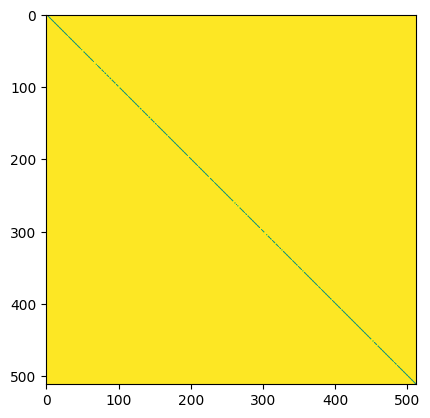

In [350]:
p = np.loadtxt("matrix-p.dat")
q = np.loadtxt("matrix-q.dat")
plt.imshow(p == q)

pd = p.diagonal()
qd = q.diagonal()
print(p / q)

In [351]:
print(pd / qd)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

In [352]:
print(qd)

[ 7.13382634e+01  5.95537378e+01  5.35513357e+01  4.71869686e+01
  5.95537378e+01  4.78539021e+01  4.71869686e+01  4.09072915e+01
  5.35513357e+01  4.71869686e+01  3.64419277e+01  3.54977192e+01
  4.18101713e+01  3.55304942e+01  3.01209219e+01  2.92614033e+01
  4.69475500e+01  3.58405442e+01  3.45807808e+01  2.88939335e+01
  3.58405442e+01  2.48182284e+01  2.88939335e+01  2.32917762e+01
  3.45807808e+01  2.88939335e+01  2.28915314e+01  2.26248427e+01
  2.35171363e+01  1.79149790e+01  1.72480454e+01  1.70660467e+01
  5.35513357e+01  4.18101713e+01  3.64419277e+01  3.01209219e+01
  4.71869686e+01  3.55304942e+01  3.54977192e+01  2.92614033e+01
  3.58490979e+01  2.95280921e+01  1.94172098e+01  1.85163625e+01
  2.95280921e+01  2.32917762e+01  1.85163625e+01  1.77002052e+01
  3.45807808e+01  2.35171363e+01  2.28915314e+01  1.72480454e+01
  2.88939335e+01  1.79149790e+01  2.26248427e+01  1.70660467e+01
  2.22987016e+01  1.66552156e+01  1.12869720e+01  1.10636445e+01
  1.66552156e+01  1.10964

## Testing more atoms with fixed amplitude and detuning Pauli term fixed checking interaction term

Interatomic Radius is: 9.756753962298905µm.


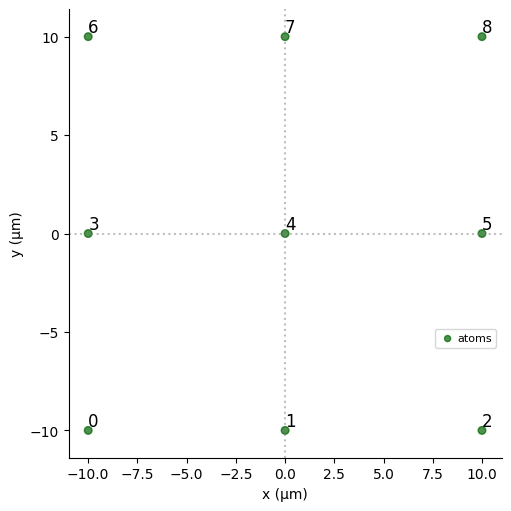

In [394]:
Omega_max = 2.0 * 2 * np.pi
U = Omega_max / 2.0
R_interatomic = MockDevice.rydberg_blockade_radius(U)
reg = Register.from_coordinates(
    [[0, 0], [10, 0], [20, 0], [0, 10], [10, 10], [20, 10], [0, 20], [10, 20], [20, 20]]
)
print(f"Interatomic Radius is: {R_interatomic}µm.")
reg.draw()

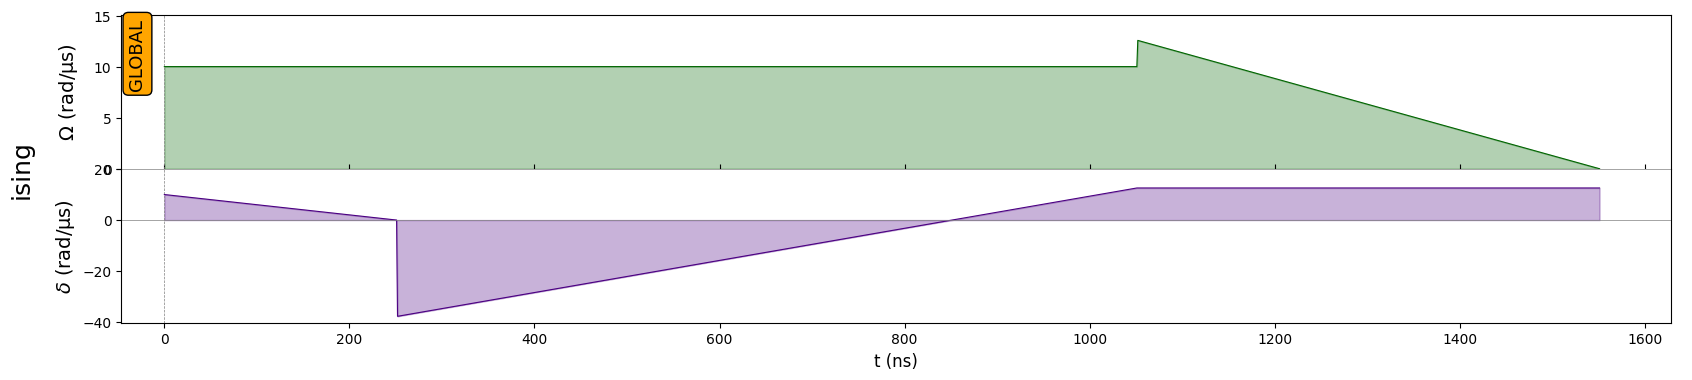

In [395]:
delta_0 = -6 * U
delta_f = 2 * U
t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000
rise = Pulse.ConstantAmplitude(10, RampWaveform(t_rise, 10.0, 0.0), 0)
sweep = Pulse.ConstantAmplitude(10, RampWaveform(t_sweep, delta_0, delta_f), 0)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0)
seq1 = Sequence(reg, MockDevice)
seq1.declare_channel("ising", "rydberg_global")

seq1.add(rise, "ising")
seq1.add(sweep, "ising")
seq1.add(fall, "ising")

seq1.draw()

In [396]:
sim = QutipEmulator.from_sequence(seq1)

In [397]:
results = sim.run(progress_bar=True)

10.0%. Run time:   0.07s. Est. time left: 00:00:00:00
20.0%. Run time:   0.14s. Est. time left: 00:00:00:00
30.0%. Run time:   0.22s. Est. time left: 00:00:00:00
40.1%. Run time:   0.30s. Est. time left: 00:00:00:00
50.0%. Run time:   0.37s. Est. time left: 00:00:00:00
60.0%. Run time:   0.43s. Est. time left: 00:00:00:00
70.1%. Run time:   0.49s. Est. time left: 00:00:00:00
80.0%. Run time:   0.55s. Est. time left: 00:00:00:00
90.0%. Run time:   0.62s. Est. time left: 00:00:00:00
Total run time:   0.68s


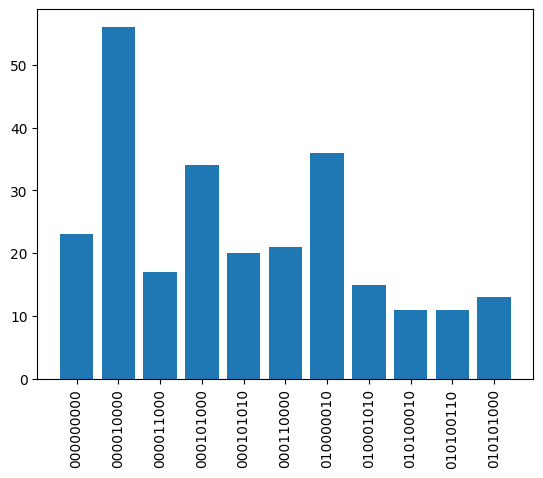

In [398]:
import matplotlib.pyplot as plt

count = results.sample_final_state()

most_freq = {k: v for k, v in count.items() if v > 10}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.show()

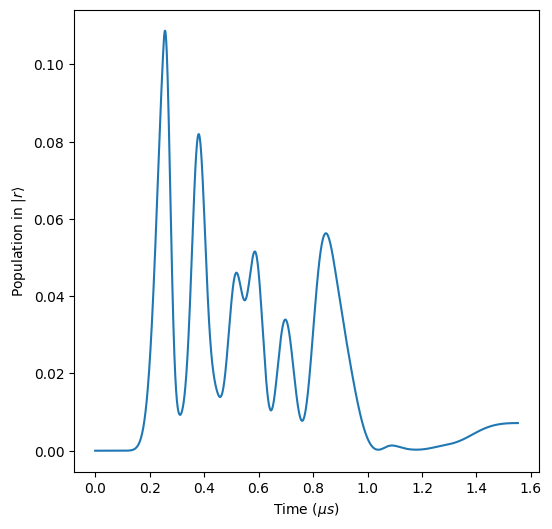

In [399]:
# Define Rydberg state observable
obs = qutip.basis(256 * 2, 0).proj()
plt.figure(figsize=(6, 6))
k = results.expect([obs])[0]

plt.plot(results._sim_times, k)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"Population in $|r\rangle$")
plt.show()

crank = 0, prank = 2
rcut is 10.0


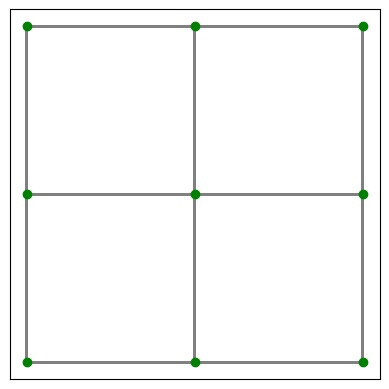

In [400]:
import qse.qbits


L = 3
nqbits = L * L
qsqr = qse.Qbits(
    positions=np.array(
        [
            [0, 0, 0],
            [10, 0, 0],
            [20, 0, 0],
            [0, 10, 0],
            [10, 10, 0],
            [20, 10, 0],
            [0, 20, 0],
            [10, 20, 0],
            [20, 20, 0],
        ]
    )
)


Omega = 1.2  # Amplitude
delta = 2.0  # detuning
C6 = 5420158.53  # interaction scale

qsqr.draw()

In [418]:
def occ_op(nqbits, qi):
    ti = qat.core.Term(1.0, "Z", [qi])
    return (1 + qat.core.Observable(nqbits, pauli_terms=[ti])) / 2


#
H1_terms = [qat.core.Term(0.5, "X", [i]) for i in range(qsqr.nqbits)]
H1 = qat.core.Observable(nqbits, pauli_terms=H1_terms)

# H2_terms = [qat.core.Term(-0.5, "Z", [i])+qat.core.Term(-0.5,"I",[i]) for i in range(qsqr.nqbits)]
# # H2_terms_Z = [qat.core.Term(-0.5, "Z", [i]) for i in range(qsqr.nqbits)]
# H2 = qat.core.Observable(nqbits, pauli_terms=H2_terms)
H2 = 0
for i in range(qsqr.nqbits):
    H2 += occ_op(qsqr.nqbits, i)
H2 = H2 * (-1)
rij = qsqr.get_all_distances()


H3 = 0

for i in range(nqbits):
    for j in range(i + 1, nqbits):
        H3 += (C6 / rij[i, j] ** 6) * occ_op(nqbits, i) * occ_op(nqbits, j)

In [419]:
from qat.core.variables import Variable, heaviside
from qat.core import Observable


def create_waveform(times, values):
    """
    A Funnction allowing us to concatenate many lines, limited by heavisides,
    thus creating a continuous, kinked line.
    """
    assert len(times) == len(values)
    # Store the final line as an ArithExpression
    arith_expr = 0
    t_var = Variable("t")
    # A line between each two points
    for entry_i in range(1, len(times)):
        # Create ax + b by calculating the slope and the offset
        a = (values[entry_i] - values[entry_i - 1]) / (
            times[entry_i] - times[entry_i - 1]
        )
        b = (
            (values[entry_i] + values[entry_i - 1])
            - a * (times[entry_i] + times[entry_i - 1])
        ) / 2
        respective_line = a * t_var + b
        arith_expr += (
            heaviside(t_var, times[entry_i - 1], times[entry_i]) * respective_line
        )
    return arith_expr


#
Omega_max = 2.0 * 2 * np.pi
U = Omega_max / 2.0

delta_0 = -6 * U
delta_f = 2 * U

t_rise = 0.252
t_fall = 0.500
t_sweep = ((delta_f - delta_0) / (2 * np.pi * 10) * 1000) * (10**-3)


# The waveform of Omega - for the sigma_x terms
omega_values = [10.0, 0, Omega_max, 0]
times_omega = [0, t_rise, t_rise + t_sweep, t_rise + t_sweep + t_fall]


omega_waveform = create_waveform(times_omega, omega_values)
# The waveform of the detuning Delta - for the 'n' terms
delta_start = -2 * np.pi * 13
delta_end = 2 * np.pi * 11  # R_blockade is taken as 7.5
delta_values = [10, 0, delta_f, delta_f]
delta_waveform = create_waveform(times_omega, delta_values)

In [420]:
from qat.core import Observable

Hamiltonian = Observable(
    [
        (omega_waveform, H1),
        (delta_waveform, H2),
    ]
)

schedule = Schedule(
    drive=[
        (omega_waveform, H1),
        (delta_waveform, H2),
    ],
    tmax=t_rise + t_sweep + t_fall,
)

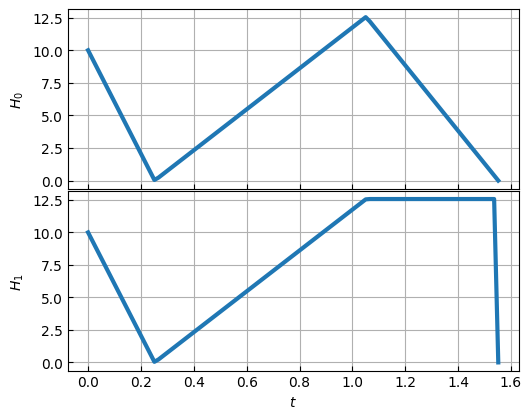

In [421]:
schedule.display()

In [422]:
matrixm = (
    10 * H1.to_matrix(sparse=False)
    + 10 * H2.to_matrix(sparse=False)
    + H3.to_matrix(sparse=False)
)

In [423]:
H2.to_matrix(sparse=False)

array([[-9.+0.j, -0.+0.j, -0.+0.j, ..., -0.+0.j, -0.+0.j, -0.+0.j],
       [-0.+0.j, -8.+0.j, -0.+0.j, ...,  0.+0.j, -0.+0.j,  0.+0.j],
       [-0.+0.j, -0.+0.j, -8.+0.j, ..., -0.+0.j,  0.+0.j,  0.+0.j],
       ...,
       [-0.+0.j,  0.+0.j, -0.+0.j, ..., -1.+0.j,  0.+0.j,  0.+0.j],
       [-0.+0.j, -0.+0.j,  0.+0.j, ...,  0.+0.j, -1.+0.j,  0.+0.j],
       [-0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j]])

[[-18.66173661+0.j   5.        +0.j   5.        +0.j ...   0.        +0.j
    0.        +0.j   0.        +0.j]
 [  5.        +0.j -20.44626222+0.j   0.        +0.j ...   0.        +0.j
    0.        +0.j   0.        +0.j]
 [  5.        +0.j   0.        +0.j -26.44866434+0.j ...   0.        +0.j
    0.        +0.j   0.        +0.j]
 ...
 [  0.        +0.j   0.        +0.j   0.        +0.j ... -10.        +0.j
    0.        +0.j   5.        +0.j]
 [  0.        +0.j   0.        +0.j   0.        +0.j ...   0.        +0.j
  -10.        +0.j   5.        +0.j]
 [  0.        +0.j   0.        +0.j   0.        +0.j ...   5.        +0.j
    5.        +0.j   0.        +0.j]]


True

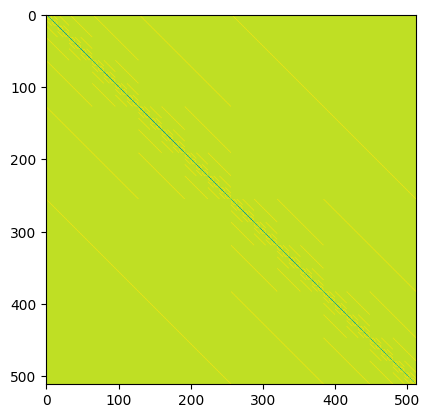

In [424]:
matrixp = sim.get_hamiltonian(0).get_data().toarray()
plt.imshow(matrixp.real)
print(matrixp)
np.savetxt("matrix-p.dat", matrixp.real)
np.all(matrixp.imag == 0)

[[-1.86617366e+01+0.j  5.00000000e+00+0.j  5.00000000e+00+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 5.00000000e+00+0.j -2.04462622e+01+0.j  0.00000000e+00+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 5.00000000e+00+0.j  0.00000000e+00+0.j -2.64486643e+01+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 ...
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
  -1.00000000e+01+0.j  0.00000000e+00+0.j  5.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
   0.00000000e+00+0.j -1.00000000e+01+0.j  5.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
   5.00000000e+00+0.j  5.00000000e+00+0.j -4.88498131e-15+0.j]]


True

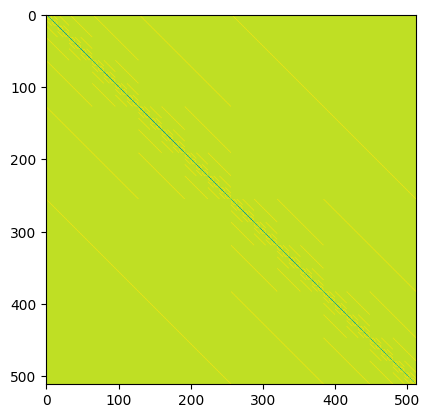

In [425]:
plt.imshow(matrixm.real)
print(matrixm)
np.savetxt("matrix-m.dat", matrixm.real)
np.all(matrixm.imag == 0)

In [426]:
np.savetxt("matrix-q.dat", matrixm.real)
np.savetxt("matrix-p.dat", matrixp.real)

[[ 1.  1.  1. ... nan nan nan]
 [ 1.  1. nan ... nan nan nan]
 [ 1. nan  1. ... nan nan nan]
 ...
 [nan nan nan ...  1. nan  1.]
 [nan nan nan ... nan  1.  1.]
 [nan nan nan ...  1.  1. -0.]]


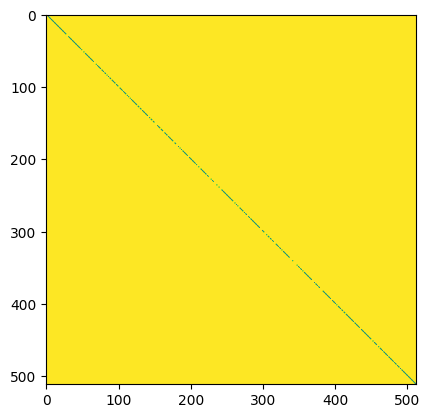

In [427]:
p = np.loadtxt("matrix-p.dat")
q = np.loadtxt("matrix-q.dat")
plt.imshow(p == q)

pd = p.diagonal()
qd = q.diagonal()
print(p / q)

In [428]:
print(pd / qd)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

In [390]:
print(q)

[[26.33826339  5.          5.         ...  0.          0.
   0.        ]
 [ 5.         24.55373778  0.         ...  0.          0.
   0.        ]
 [ 5.          0.         18.55133566 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 35.          0.
   5.        ]
 [ 0.          0.          0.         ...  0.         35.
   5.        ]
 [ 0.          0.          0.         ...  5.          5.
  45.        ]]


In [389]:
print(p)

[[-18.66173661   5.           5.         ...   0.           0.
    0.        ]
 [  5.         -20.44626222   0.         ...   0.           0.
    0.        ]
 [  5.           0.         -26.44866434 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... -10.           0.
    5.        ]
 [  0.           0.           0.         ...   0.         -10.
    5.        ]
 [  0.           0.           0.         ...   5.           5.
    0.        ]]


In [ ]:
def occ_op(nqbits, qi):
    ti = qat.core.Term(1.0, "Z", [qi])
    return (1 + qat.core.Observable(nqbits, pauli_terms=[ti])) / 2

In [416]:
qubits = qse.Qbits(positions=np.array([[0, 0, 0]]))
H2 = 0
for i in range(qubits.nqbits):
    H2 += occ_op(qubits.nqbits, i)
H2 = H2 * (-1)
rij = qubits.get_all_distances()

In [417]:
H2.to_matrix(sparse=False)

array([[-1.+0.j, -0.+0.j],
       [-0.+0.j,  0.+0.j]])